<a href="https://colab.research.google.com/github/Rogerio-mack/Ciencia-de-Dados-e-Aprendizado-de-Maquina/blob/main/CDA_Modelo_Arima_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right"> 
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->

# ARIMA Lab

In [ ]:
#@markdown imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# Conceitos importantes 
Os modelos Autoregressive Integrated Moving Average (ARIMA) fornecem uma abordagem para a previsão de séries temporais visando a descrever as autocorrelações nos dados. Antes de introduzirmos os modelos ARIMA, devemos primeiro discutir o conceito de estacionariedade e a técnica de diferenciação de séries temporais.

In [ ]:
# Séries temporais
df1=pd.read_excel("https://www.orlandoalbarracin.com.br/phyton/Series.xlsx", sheet_name="Exportações") #IBGE - Trimestral
df2=pd.read_excel("https://www.orlandoalbarracin.com.br/phyton/Series.xlsx", sheet_name="dolar") #Economial UOL - diária
df3=pd.read_excel("https://www.orlandoalbarracin.com.br/phyton/Series.xlsx", sheet_name="Vendas") #IBGE - mensal

## Estacionariedade

A média e a variância de **processos estacionários** são constantes ao longo do tempo, intuitivamente isto significa que as observações se desenvolvem aleatoriamente entorno de um certo nível com variabilidade constante.


### Exemplo.

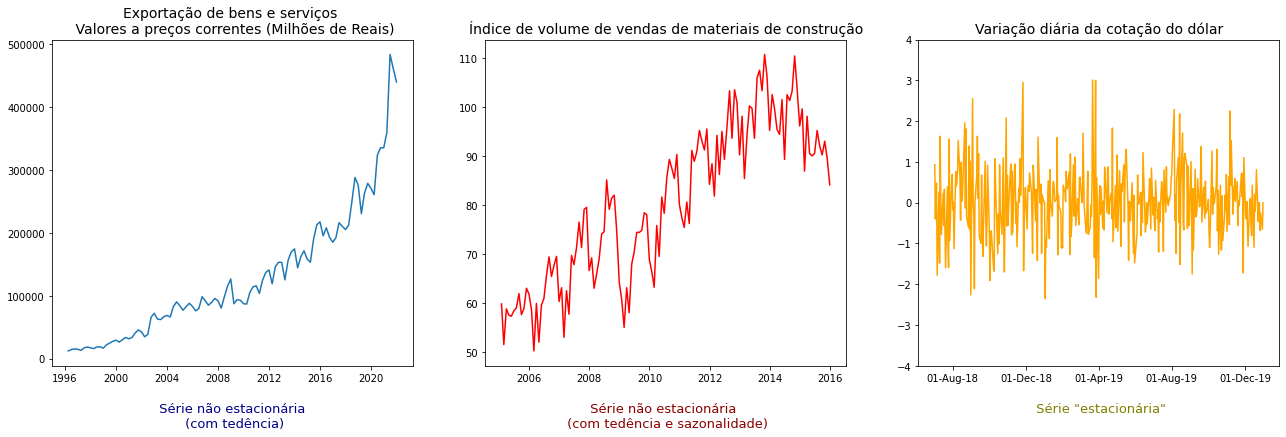

In [ ]:
#@markdown Gráfico das séries
import matplotlib.dates as mdates

index_dates1 = pd.date_range(start='3/1/1996', end='12/31/2021', freq='3M')
index_dates2 = pd.date_range(start='7/2/2018', end='12/31/2019', freq='B')
index_dates3 = pd.date_range(start='1/1/2005', end='12/31/2015', freq='M')

df1.index=index_dates1
df2.index=index_dates2
df3.index=index_dates3

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(22,6))
ax1.plot(df1.index, df1.Exportações)
ax1.set_title('Exportação de bens e serviços \n Valores a preços correntes (Milhões de Reais)',fontdict = {'fontsize' : 14})
ax1.set_xlabel('\n Série não estacionária \n (com tedência)',fontdict = {'fontsize' : 13},color="darkblue")

ax2.plot(df3.index, df3["volume_vendas"], c='r')
ax2.set_title('Índice de volume de vendas de materiais de construção',fontdict = {'fontsize' : 14})
ax2.set_xlabel('\n Série não estacionária  \n (com tedência e sazonalidade)',fontdict = {'fontsize' : 13},color="darkred")


ax3.plot(df2.index.to_pydatetime(), df2["Var"], c='orange')
ax3.xaxis.set_major_locator(mdates.MonthLocator([4,8,12]))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ax3.set_title('Variação diária da cotação do dólar',fontdict = {'fontsize' : 14})
ax3.set_xlabel('\n Série "estacionária"',fontdict = {'fontsize' : 13},color="olive")

ax3.set_ylim([-4, 4]);


## Função de autocorrelação

No processo de identificação de modelos ARIMA, a análise da estrutura de dependência serial dos dados é fundamental. Em algumas séries, observa-se que o valor atual está correlacionado com seus valores passados e a força dessa dependência diminui quando considerados valores mais distantes no tempo ("lags").


A função de autocorrelacão (ACF) permite visualizar as correlaçãoes entre observações distantes k períodos de tempo. Assim, para um "lag=1" representa-se como valores sucessivos da série estão correlacionados. Cabe ressaltar que para um "lag=0" o valor da correlação sempre será um, por que?

Na função de autocorrelação amostral intervalos de confiança de 95% são traçados para verificar se as autocorrelações são significativamente diferentes de zero.

**Observação!** Recomenda-se analisar o ACF de **série estacionárias**. As séries **não estacionárias** possuem um ACF com decaimento muito lento e não é possível analisar seus valores.

### **Exemplo**. 
A seguir apresenta-se o ACF de uma série (simulada) cujos valores sucessivos estão correlacionados. A série foi gerada de tal forma que a correlação entre o valor no instante $t$ e $t-1$ seja de $0,7$. Note que a correlação da série no instate $t$ e $t-k$ diminuiu quando $k$ aumenta, i.e, quando analisamos a correlação da série no instante $t$ com valores mais distantes no tempo. Faz sentido, não?

In [ ]:
#@markdown Simulando uma série com valores sucessivos autocorrelacionados
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_process import ArmaProcess
ar1 = np.array([1,-0.7])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1,ma1)
simulated_data = AR_object1.generate_sample(nsample=1000);


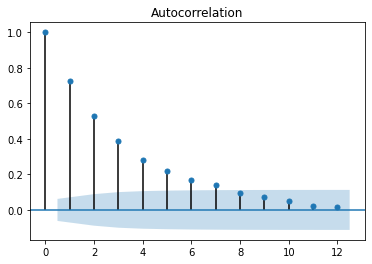

In [ ]:
# ACF
from statsmodels.graphics.tsaplots import plot_acf
x=plot_acf(simulated_data, lags=12)

Note que a correlação que considera valores sucessivos ($Z_t$ e $Z_{t-1}$, ou seja, $lag=1$) é de 0,7 e essas correlações decaem exponencialmente quando analisadas as associações entre valores mais distantes. Observa-se que para valores "muito" distantes no tempo (lags >7) a correlação é zero estatísticamente falando.

### Função de autocorrelação parcial (PACF)

As autocorrelações parciais são usadas para medir o graus de associação entre $Z_{t}$ e $Z_{t-k}$, quando os efeitos das outras defasagens são removidos.

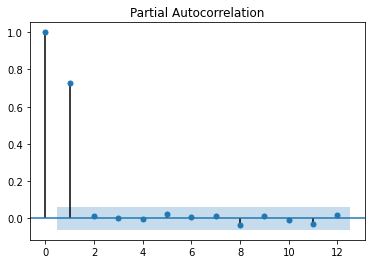

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
x=plot_pacf(simulated_data, lags=12);

Obseva-se que somente a correlação do lag=1 é significativamente diferente de zero, ou seja, para tentar entender o valor da série no instante $"t"$ podemos usar a informação contida no instante $"t-1"$.

## Diferenciação

Muitas séries analisadas na prática são não estacionárias, mas ao tomarmos algumas diferenças a série se torna estacionária.  Tomando-se uma diferença elimina-se uma tendência linear. 




Seja $Z_t$ o valor da série no instante $t$. A primeira diferença é dada por:

$$ \Delta Z_t = Z_t -Z_{t-1} $$

Em geral, tomar uma ou duas diferenças é suficiente para eliminar tendências da série e torná-la estacionária.

Quando a série é sazonal  é apropriado tomar as diferenças para o período de
sazonalidade. Considere o caso de uma série mensal cujos valores apresentam um comportamento períodico que se repete a cada ano. Assim, recomenda-se tomar uma diferença sazonal

$$ \Delta Z_t = Z_t -Z_{t-12} $$


### Exemplo (eliminar a tendência)

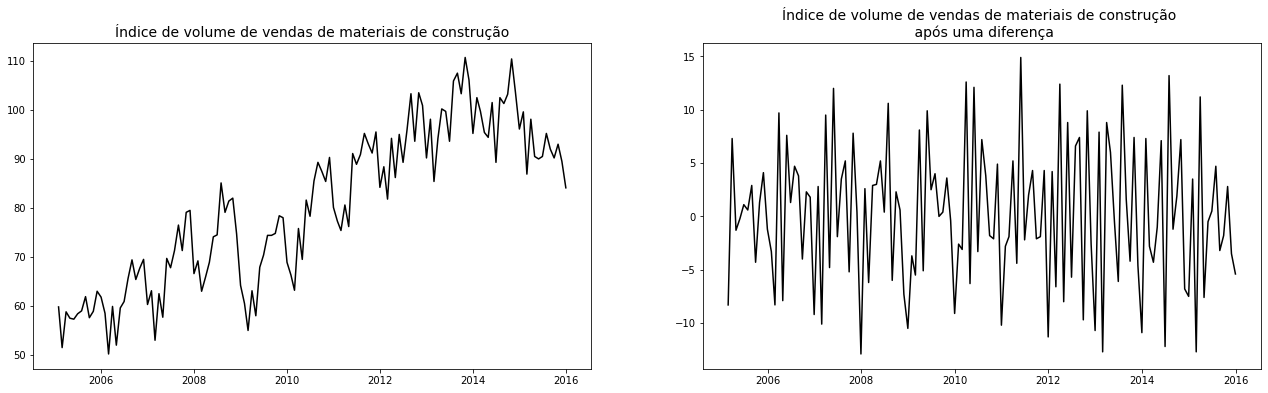

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(22,6))

# Série original
ax1.plot(df3.index, df3["volume_vendas"],color="black")
ax1.set_title('Índice de volume de vendas de materiais de construção',fontdict = {'fontsize' : 14})

# Série diferenciada
ax2.plot(df3.index, df3["volume_vendas"].diff(),color="black")
ax2.set_title('Índice de volume de vendas de materiais de construção \n após uma diferença',fontdict = {'fontsize' : 14})

plt.show()

Note que após uma diferença eliminou-se a tendência da série.

# Ajustando um modelo ARIMA
Os modelos ARIMA permitem modelar processos chamados de não estacionários homogêneos, denotado por ARIMA(p,d,q), em d indica o número de diferenças necessárias para que a série se torne estacionária, p é o número total de termos defasados $(Z_{t-1}, Z_{t-2},...,Z_{t-p})$ da série que que influenciam no instante $t$ (parte Autorregressiva (AR) do modelo), e $q$ o número total de termos defasados de erros aleatórios $(e_{t-1}, e_{t-2},...,e_{t-q})$ correspondente à parte de Médias móveis (MA), sua interpretação é menos intuitiva.


$$\underbrace{\Delta^d Z_t}_\text{Série após d diferenças} =\mu+ \underbrace{\phi_1 \Delta^dZ_{t-1}+ \phi_2\Delta^dZ_{t-2}+...+\phi_p\Delta^d Z_{t-p}}_\text {Autorregressiva (AR)} + e_t + \underbrace{\theta_1e_{t-1}+ \theta_2 e_{t-2}+...+ \theta_q e_{t-q}}_\text{Médias móveis (MA)}, $$

em que $\phi_1,...,\phi_p, \theta_1,...,\theta_q$ são valores a serem estimados. Geralmente $e_t \sim N (0,\sigma^2)$.

## Pasos a serem considerados quando ajustamos um modelo ARIMA

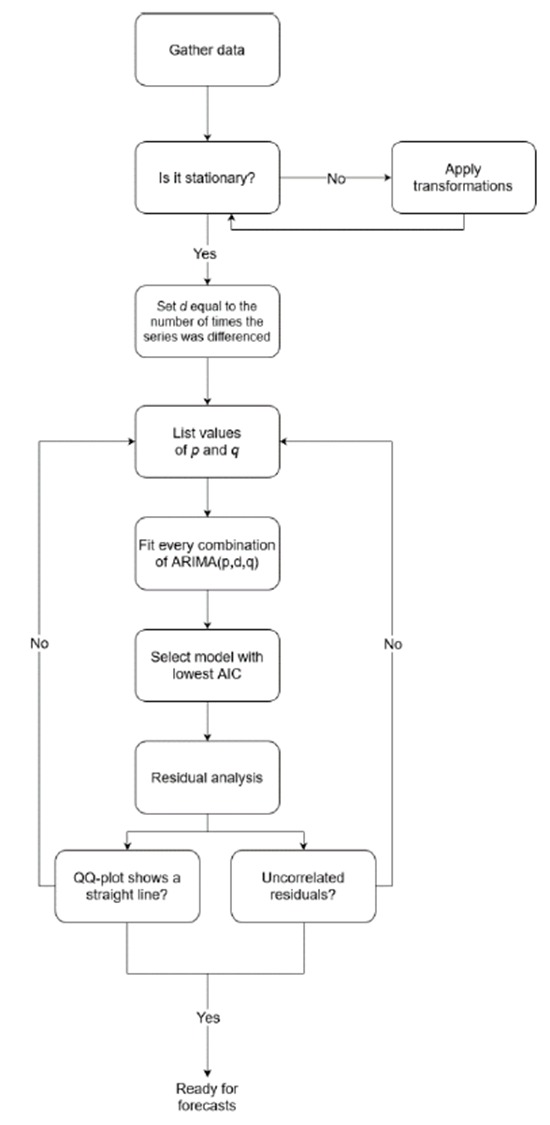

# Exemplo

Considere a série das vendas médias semanais registradas numa loja de produtos eletrônicos do setor varejista do Brasil. Link: "https://www.orlandoalbarracin.com.br/phyton/Vendas.xlsx"

In [ ]:
df=pd.read_excel("https://www.orlandoalbarracin.com.br/phyton/Vendas.xlsx") 
df.index = pd.to_datetime(df['Data'], format='%Y-%m-%d')
df=df.drop(columns="Data")
df.head()

## 1.1.  Verifique, por meio de um gráfico, se aparentemente a série temporal é ou não estacionária?

In [ ]:
plt.figure(figsize=(10,4))


Nota-se que ...

## 1.2. Apresente a função de autocorrelação da série, o que podemos observar?

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf


Nota-se ...

## 1.3. Faça um gráfico da diferença da série. Essa série é aparentemente estacionária? Verifique usando o teste de Dickey-Fuller
Dica: Usar a função adfulller.

*   Se p-value > 0.05. Não se rejeita H0, há uma raiz unitária e a série é não estacionária

*  Se p-value < 0.05. Rejeita H0, não há uma raiz unitária e a série é estacionária

In [ ]:
#Gráfico da série diferenciada
plt.figure(figsize=(10,4))


Nota-se que ...

In [ ]:
from statsmodels.tsa.stattools import adfuller



Como o valor-p ...

## 1.4. Usando a função de autocorrelação parcial e a série diferenciada, comente quais valores defasados (lags) da série seriam interessantes considerá-los num modelo ARIMA. 

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf


Nota-se que seria interessante considerar os termos defassados...

## 1.5. Ajuste um modelo ARIMA (5,1,0) para a série (deixe as últimas 12 semanas para testar a habilidade do modelo para fazer previsões). Os termos autorregressivos "ar.L4.Vendas" e "ar.L5.Vendas" são significativos? 

In [ ]:
a=len(df)-12
train = df[:a]
test = df[a:]

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model_1=ARIMA(train, order=(, , 0))


Note que somente os termos referentes às defasagens ...

## 1.6. Faça uma análise dos resíduos do modelo anterior

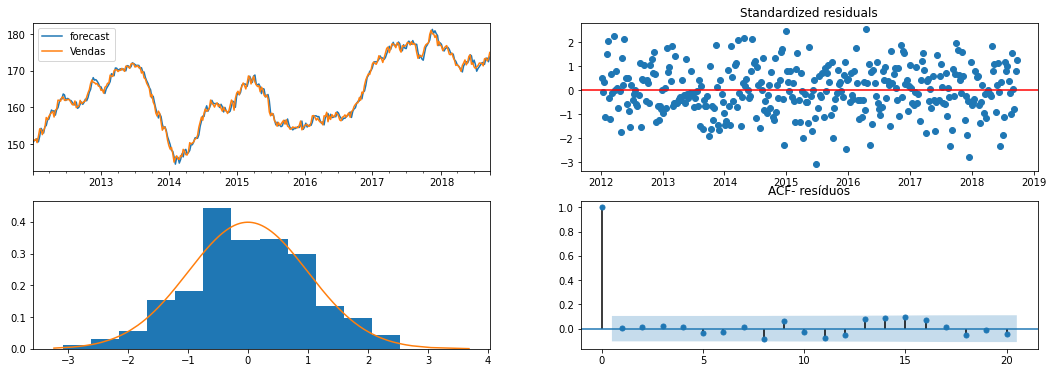

In [ ]:
#@markdown Arima - Análise dos resíduos
fig,axs = plt.subplots(2, 2,figsize=(18,6))

#axs[0,0].plot(res.predict(typ='levels'),color="red")
#axs[0,0].plot(df.valor,color="blue")
res.plot_predict(dynamic=False, ax=axs[0,0])

axs[0,1].scatter(df.index[1:len(train)],(res.resid-res.resid.mean())/np.sqrt(res.resid.var())) #standardized residuals
axs[0,1].axhline(y=0, color='r', linestyle='-')

axs[0,1].set_title('Standardized residuals')

axs[1,0].hist((res.resid-res.resid.mean())/np.sqrt(res.resid.var()), density=True, bins=12);
x=np.sort(np.random.normal(0, 1, 1000))
axs[1,0].plot(x, stats.norm.pdf(x, 0, 1))

x=plot_acf((res.resid-res.resid.mean())/np.sqrt(res.resid.var()), lags=20, ax=axs[1,1], title="ACF- resíduos");
#x1=plot_pacf(res.resid, lags=20, ax=axs[1,1], title="PACF- resíduos")

Nota-se que os resíduos ...

## 1.7. Faça um gráfico visualizando os valores previsto pelo modelo e os valores observados (parte test)!

In [ ]:
#@markdown forecast h=12

# Chamar df sua base de dados e valor as observações da série

# Create Training and Test
a=len(df)-12
train = df[:a]
test = df[a:]

# Build Model
model = ARIMA(train, order=(5, 1, 0))  
fitted = model.fit()  
#print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='Observado')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

##1.8 Avalie o desempenho desse modelo para fazer previsões

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'mae': mae, 'rmse':rmse})

## 1.9. Selecione o melhor modelo usando como critério AIC (menor valor de AIC, melhor o ajuste). Considere os modelos ARIMA (p,1,q). Use valores de p={0,1,2,3,4,5} e q={0,1,2}.

In [ ]:
# Completar o código 

AIC=list()
P=list()
Q=list()
for p in list(range(6)):
  for q in list(range(3)):


In [ ]:
result_AIC=pd.DataFrame(list(zip(P, Q,AIC)),columns =['P', 'Q', 'AIC'])
result_AIC.sort_values(by="AIC", axis=0)